# LSTM para previsão de casos do COVID-19

Aplicação da rede LSTM desenvolvida e disponibilizada por Luis Ricardo e Marcos Rodrigues.

O código foi organizado e aplicado como requisto para o trabalho de Matemática Computacional (CAP-239-4)

## Definição das funções do modelo


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# univariate data preparation
import numpy as np
from numpy import array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Flatten
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from numpy import array 
from numpy import hstack 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math, pickle, csv, os, warnings

path = os.getcwd() # Diretório atual

Using TensorFlow backend.


In [2]:
def organizar_dados(path_input,tipo_analise,pais):
    path = os.path.join(path_input, tipo_analise)
    list_files_analise = os.listdir(path)
    list_files_analise.sort()
    serie_analise = pd.read_csv(os.path.join(path, list_files_analise[0]), 
                                  header = None, engine = 'python')
    select_analise = serie_analise[serie_analise[0] == pais]
    select_analise = select_analise[[0, 2, 3]]
    return select_analise


def split_sequences(sequences, n_steps_in, n_steps_out):
    '''
    Brownlee, J. (2018). Deep Learning for Time Series Forecasting: 
    Predict the Future with MLPs, CNNs and LSTMs in Python. 
    Machine Learning Mastery.
    '''
    X, y = list(), list() 
    for i in range(len(sequences)): 
        #find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        #check if we are beyond the dataset 
        if out_end_ix > len(sequences): 
            break 
        #gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix] 
        X.append(seq_x) 
        y.append(seq_y) 
    return X, y

def preparar_dados(dados_covid, n_dias_entrada, n_dias_saida):    
    # choose a number of time steps 
    # covert into input/output
    dados_covid = dados_covid.iloc[:,2]
    dados_covid = np.float64(dados_covid.tolist())
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = dados_covid.reshape(-1, 1)
    data = scaler.fit_transform(data)
    data = data.reshape(len(data),)
    
    X, y = split_sequences(data, n_dias_entrada, n_dias_saida)
    
    inputarray = data[-n_dias_entrada:]
    inputarray = [float(i) for i in inputarray]
    inputarray = np.asarray(inputarray)

    X = np.float64(X)
    y = np.float64(y)    
    return data, X,y, inputarray,scaler


def definir_modelo_lstm_simples(modelo,n_dias_entrada, n_dias_saida):
    n_features = 1
    modelo.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_dias_entrada, n_features)))
    modelo.add(LSTM(200, activation='relu'))
    modelo.add(Dense(n_dias_saida))
    
    modelo.compile(optimizer='adam', loss='mse')
    return modelo

def treinamento(X,y,modelo,epocas,batch):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # fit model
    history = modelo.fit(X, y, epochs=epocas,batch_size=batch)

    return history

def predict(modelo,inputarray,n_dias_entrada):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    return y_future

def validacao(modelo,n_dias_entrada,inputarray):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    
    return y_future
   
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    

def carregaModelo(nomeModelo):
    carrega_modelo = pickle.load(open(nomeModelo+'.sav', 'rb'))
    return carrega_modelo

**Função para treinamento automatizado**

In [3]:
def gerarTreinamento_parametros(pais,version,n_entradas,n_saidas, epochs = 50, batch = 1):
    #Parametros: (path_input,tipo_analise,pais)
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    
    #Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback oringial data
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entradas, n_saidas)
    
    ##Parametros: (modelo,n_dias_entrada, n_dias_saida)
    modelo = Sequential()
    modelo = definir_modelo_lstm_simples(modelo,n_entradas, n_saidas)
    
    #Parametros: (X,y,modelo,epocas,batch)
    history = treinamento(X, y, modelo, epochs, batch)
    #cria dicionario
    history = history.history
    history.keys()
    
    #Salvando Dicionario
    salvardicionario("History_" + pais + "_" + version, history)
    salvarmodelo("Modelo_" + pais + "_" + version, modelo)

**Função para validação**

In [4]:
def geraValidacao(pais, modelo, n_entrada, n_saida, plt_title = "RMSE: {rmse}"):
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)
    
    #Carrega modelo já Treinado
    modelo = carregaModelo(modelo)
    
    list_pred = []
    for i in range(0, 130, n_saida):
        try:
          input_array_test =  np.array(dados_covid[i:(i+n_entrada)])
          if len(input_array_test) < n_entrada:
            input_array_test = np.append(input_array_test,[0],axis = None)
          y_predict_val_test = predict(modelo,input_array_test,n_entrada)
          list_pred.append(y_predict_val_test)
        except:
          warnings.warn("Problema na lógica de separação para predição", RuntimeWarning)
    
    plt.figure()
    concatenado = np.concatenate((list_pred[:]))
    true = dados_covid[n_entrada:len(concatenado)+n_entrada]

    if len(true) < len(concatenado):
        print("entrou condi")
        lim = (len(concatenado) - len(true))
        concatenado = concatenado[0:len(concatenado) - lim]
        
    score_rmse = math.sqrt(mean_squared_error(concatenado, true))
    plt.figure(dpi = 150)
    plt.plot(concatenado,'r--', label = 'Valores preditos')
    plt.plot(true,'b',label = 'Valores reais')
    plt.xlabel('Dias')
    plt.ylabel('Casos diários')
    plt.legend(loc ='upper right')
    plt.title(plt_title.format(rmse = str(round(score_rmse, 4))))
    # plt.title('RMSE: %.4f' % (score_rmse))
    
    return score_rmse

In [5]:
os.makedirs('Number_Daily_Cases', exist_ok = True)

# Funções auxiliares

Esta seção apresenta funções auxiliares para múltiplas execuções. Criado para os testes do trabalho da disciplina de Matemática Computacional (CAP-239-4)

In [6]:
def multiplas_execucoes(pais, padroes_de_entrada, plt_title, epochs_range = None, is_walk = False, **kwargs):
  class EpochsChange(RuntimeWarning): ...
  
  def treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs):
    VERSAOT = "v{num}"
    results = {
      'nome_modelo': [],
      'versao': [],
      'entradas': [],
      'rmse': [],
      'epoch': []
    }
    
    for padrao_de_entrada, num in zip(padroes_de_entrada, range(len(padroes_de_entrada))):
      versaot = VERSAOT.format(num = num)
      nmodelo = f"Modelo_{pais}_{versaot}"
      print(nmodelo)

      gerarTreinamento_parametros(pais, versaot, *padrao_de_entrada, **kwargs)
      results['nome_modelo'].append(nmodelo)
      results['versao'].append(versaot)
      results['entradas'].append(padrao_de_entrada)
      
      if kwargs['epochs']:
        results['epoch'].append(kwargs['epochs'])
      else:
        results['epoch'].append(50) # Padrão de épocas

      results['rmse'].append(
          geraValidacao(pais, nmodelo, *padrao_de_entrada, plt_title = plt_title)
      )
    return pd.DataFrame(results)

  if not epochs_range:
    return treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs)
  else:
    warnings.warn("O programa está sendo executado no modo de múltiplas épocas", EpochsChange)
    # Identificando se são passos ou intervalos
    if is_walk:
      _loop = epochs_range
    else:
      _loop = range(*epochs_range)

    res = []
    for i in _loop:
      res.append(treina_modelo(pais, padroes_de_entrada, plt_title, epochs = i))
    return pd.concat(res)
  raise RuntimeError("Os parâmetros inseridos são inválidos")

# Organização dos dados

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('blueteam_national_update_2020_06_03.csv')
df = df[~df.new_confirmed.isna()]

**Organizando os dados**

Abaixo, os dados são organizados para o formato utilizado no código de LSTM desenvolvido e disponibilizado pelo Luis Ricardo e Marcos Rodrigues

> A estrutura dos dados é organizada e salva em um arquivo, da mesma forma como definido no programa original

In [10]:
national_nt = df[df['state'] == 'RJ']
national_nt = national_nt[national_nt['is_repeated'] == False]

national_nt.set_index('date', inplace = True)
national_nt = national_nt.sort_index()
national_nt = national_nt.groupby(['date', 'state']).sum()
national_nt = national_nt[national_nt.new_confirmed > 0]
national_nt.reset_index(inplace = True)

Adaptando os dados para o formato das ferramentas

In [12]:
serie_cases = pd.DataFrame({
    0: np.repeat('Niteroi', len(national_nt.index)),
    1: np.arange(0, len(national_nt.index)),
    2: national_nt.date.values,
    3: national_nt.new_confirmed.values
})

serie_cases.to_csv("Number_Daily_Cases/daily-cases-covid-19.csv", index = False)

# Execução do modelo

**Predizendo valores para um país**

In [13]:
gerarTreinamento_parametros("Niteroi", "v1", 20, 10, epochs = 5)

Epoch 1/5
30/30 [==============================] - 1s 44ms/step - loss: 0.0588
Epoch 2/5
30/30 [==============================] - 1s 25ms/step - loss: 0.0530
Epoch 3/5
30/30 [==============================] - 1s 25ms/step - loss: 0.0523
Epoch 4/5
30/30 [==============================] - 1s 25ms/step - loss: 0.0509
Epoch 5/5
30/30 [==============================] - 1s 26ms/step - loss: 0.0515


entrou condi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


<Figure size 432x288 with 0 Axes>

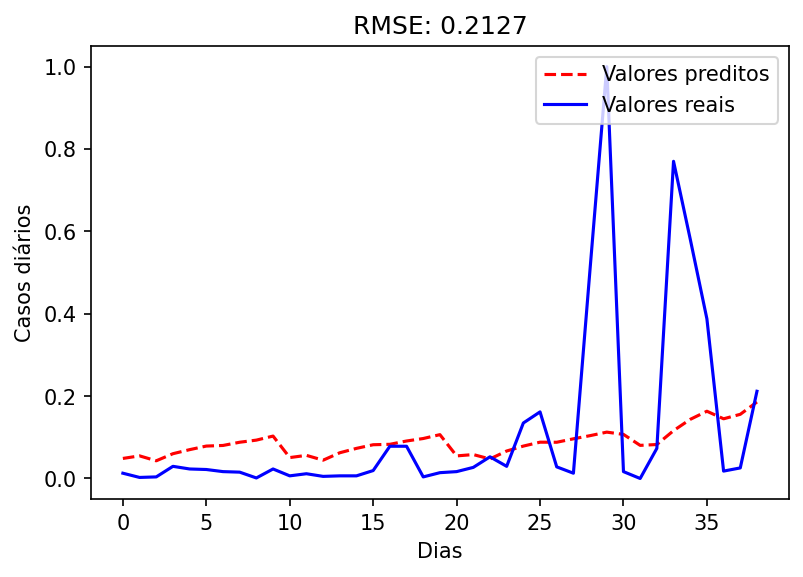

In [14]:
# pontos de entrada
n_entrada = 20
# pontos de saida
n_saida = 10
score_portugal_1 = geraValidacao("Niteroi", "Modelo_Niteroi_v1", n_entrada, n_saida)

# Múltiplas execuções

Nesta seção, múltiplas execuções são feitas para teste dos parâmetros.

## Epoch único

**Minas Gerais**

Modelo_Niteroi_v0
Epoch 1/2
43/43 [==============================] - 1s 27ms/step - loss: 0.0460
Epoch 2/2
43/43 [==============================] - 1s 15ms/step - loss: 0.0425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/2
33/33 [==============================] - 1s 39ms/step - loss: 0.0573
Epoch 2/2
33/33 [==============================] - 1s 22ms/step - loss: 0.0520


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/2
23/23 [==============================] - 1s 54ms/step - loss: 0.0840
Epoch 2/2
23/23 [==============================] - 1s 35ms/step - loss: 0.0702


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v3
Epoch 1/2
30/30 [==============================] - 1s 43ms/step - loss: 0.0582
Epoch 2/2
30/30 [==============================] - 1s 24ms/step - loss: 0.0539


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi


<Figure size 432x288 with 0 Axes>

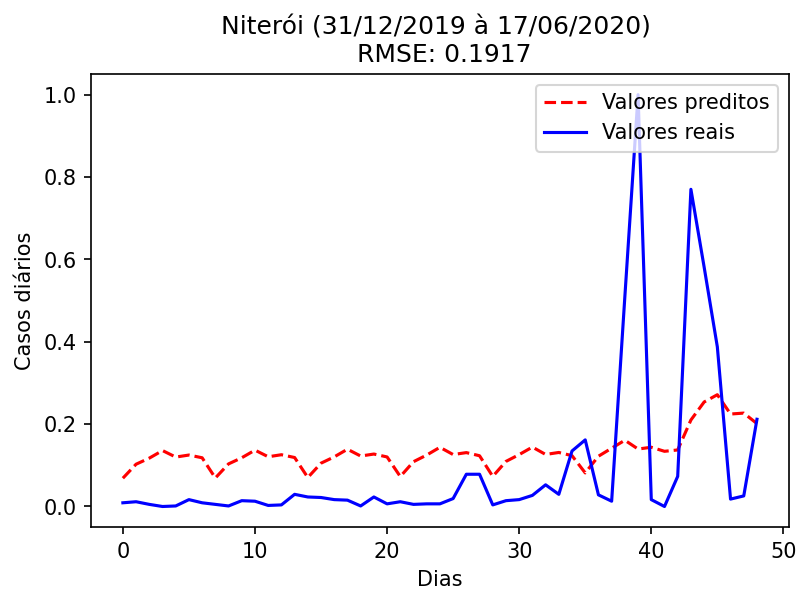

<Figure size 432x288 with 0 Axes>

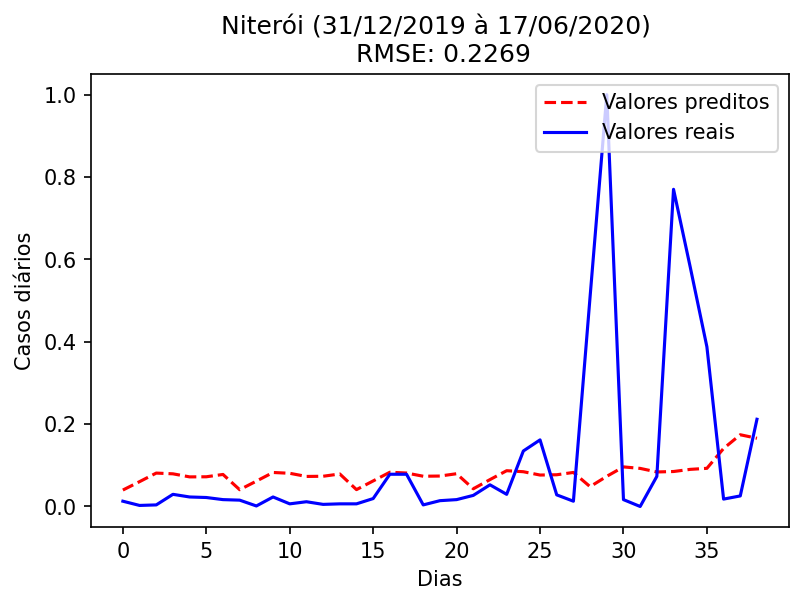

<Figure size 432x288 with 0 Axes>

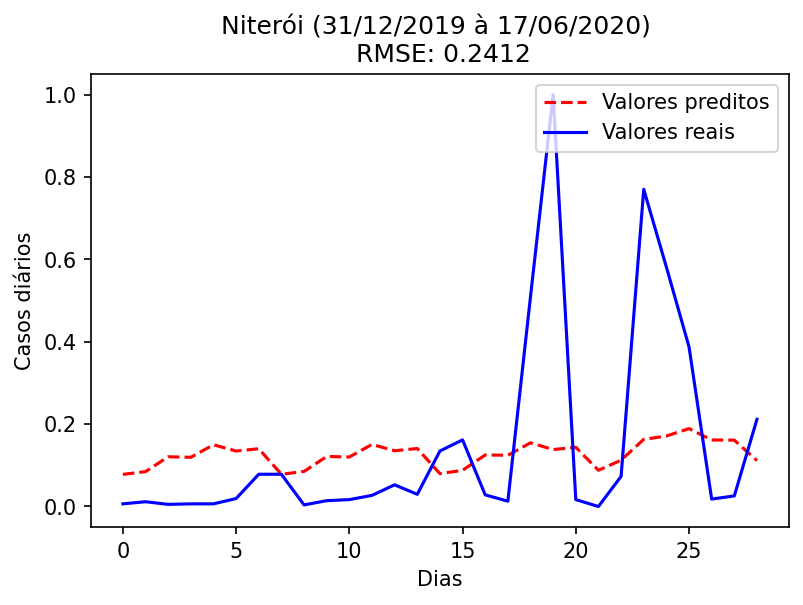

<Figure size 432x288 with 0 Axes>

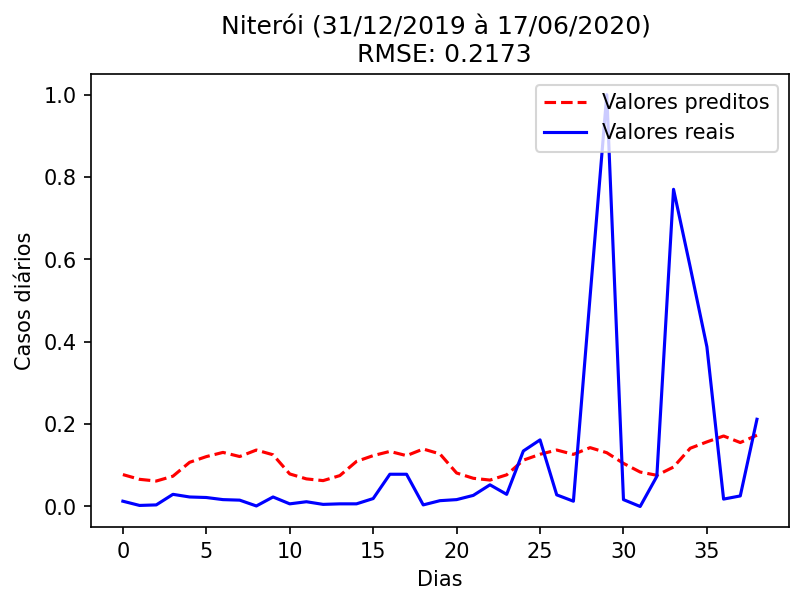

In [15]:
mg_params = multiplas_execucoes("Niteroi", [(10, 7), (20, 7), (30, 7), (20, 10)], 
                                "Niterói (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

## Epoch múltiplos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Niteroi_v0
Epoch 1/5
43/43 [==============================] - 1s 27ms/step - loss: 0.0459
Epoch 2/5
43/43 [==============================] - 1s 14ms/step - loss: 0.0422
Epoch 3/5
43/43 [==============================] - 1s 14ms/step - loss: 0.0403
Epoch 4/5
43/43 [==============================] - 1s 14ms/step - loss: 0.0368
Epoch 5/5
43/43 [==============================] - 1s 14ms/step - loss: 0.0370


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/5
33/33 [==============================] - 2s 46ms/step - loss: 0.0587
Epoch 2/5
33/33 [==============================] - 2s 51ms/step - loss: 0.0536
Epoch 3/5
33/33 [==============================] - 2s 58ms/step - loss: 0.0513
Epoch 4/5
33/33 [==============================] - 2s 54ms/step - loss: 0.0487
Epoch 5/5
33/33 [==============================] - 1s 45ms/step - loss: 0.0480


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/5
23/23 [==============================] - 1s 62ms/step - loss: 0.0861
Epoch 2/5
23/23 [==============================] - 1s 39ms/step - loss: 0.0710
Epoch 3/5
23/23 [==============================] - 1s 39ms/step - loss: 0.0701
Epoch 4/5
23/23 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 5/5
23/23 [==============================] - 1s 37ms/step - loss: 0.0674


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v0
Epoch 1/10
43/43 [==============================] - 1s 28ms/step - loss: 0.0457
Epoch 2/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0427
Epoch 3/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0405
Epoch 4/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0395
Epoch 5/10
43/43 [==============================] - 1s 16ms/step - loss: 0.0388
Epoch 6/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0362
Epoch 7/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0386
Epoch 8/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0397
Epoch 9/10
43/43 [==============================] - 1s 15ms/step - loss: 0.0365
Epoch 10/10
43/43 [==============================] - 1s 14ms/step - loss: 0.0355


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/10
33/33 [==============================] - 1s 41ms/step - loss: 0.0589
Epoch 2/10
33/33 [==============================] - 1s 26ms/step - loss: 0.0526
Epoch 3/10
33/33 [==============================] - 1s 26ms/step - loss: 0.0515
Epoch 4/10
33/33 [==============================] - 1s 24ms/step - loss: 0.0500
Epoch 5/10
33/33 [==============================] - 1s 26ms/step - loss: 0.0493
Epoch 6/10
33/33 [==============================] - 1s 26ms/step - loss: 0.0484
Epoch 7/10
33/33 [==============================] - 1s 25ms/step - loss: 0.0467
Epoch 8/10
33/33 [==============================] - 1s 24ms/step - loss: 0.0465
Epoch 9/10
33/33 [==============================] - 1s 25ms/step - loss: 0.0452
Epoch 10/10
33/33 [==============================] - 1s 27ms/step - loss: 0.0475


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/10
23/23 [==============================] - 1s 58ms/step - loss: 0.0866
Epoch 2/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0727
Epoch 3/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0701
Epoch 4/10
23/23 [==============================] - 1s 37ms/step - loss: 0.0682
Epoch 5/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0686
Epoch 6/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0672
Epoch 7/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0653
Epoch 8/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0635
Epoch 9/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0640
Epoch 10/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0645


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v0
Epoch 1/20
43/43 [==============================] - 1s 28ms/step - loss: 0.0455
Epoch 2/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0431
Epoch 3/20
43/43 [==============================] - 1s 15ms/step - loss: 0.0401
Epoch 4/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 5/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0394
Epoch 6/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0378
Epoch 7/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0368
Epoch 8/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0361
Epoch 9/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0364
Epoch 10/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0362
Epoch 11/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0353
Epoch 12/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0355
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0570
Epoch 2/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0540
Epoch 3/20
33/33 [==============================] - 1s 27ms/step - loss: 0.0517
Epoch 4/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0504
Epoch 5/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0466
Epoch 6/20
33/33 [==============================] - 1s 27ms/step - loss: 0.0609
Epoch 7/20
33/33 [==============================] - 1s 28ms/step - loss: 0.0542
Epoch 8/20
33/33 [==============================] - 1s 27ms/step - loss: 0.0512
Epoch 9/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0500
Epoch 10/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0489
Epoch 11/20
33/33 [==============================] - 1s 26ms/step - loss: 0.0484
Epoch 12/20
33/33 [==============================] - 1s 25ms/step - loss: 0.0483
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/20
23/23 [==============================] - 1s 59ms/step - loss: 0.0849
Epoch 2/20
23/23 [==============================] - 1s 36ms/step - loss: 0.0697
Epoch 3/20
23/23 [==============================] - 1s 37ms/step - loss: 0.0704
Epoch 4/20
23/23 [==============================] - 1s 38ms/step - loss: 0.0691
Epoch 5/20
23/23 [==============================] - 1s 38ms/step - loss: 0.0700
Epoch 6/20
23/23 [==============================] - 1s 37ms/step - loss: 0.0668
Epoch 7/20
23/23 [==============================] - 1s 35ms/step - loss: 0.0687
Epoch 8/20
23/23 [==============================] - 1s 36ms/step - loss: 0.0657
Epoch 9/20
23/23 [==============================] - 1s 34ms/step - loss: 0.0644
Epoch 10/20
23/23 [==============================] - 1s 35ms/step - loss: 0.0636
Epoch 11/20
23/23 [==============================] - 1s 35ms/step - loss: 0.0634
Epoch 12/20
23/23 [==============================] - 1s 36ms/step - loss: 0.0623
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v0
Epoch 1/50
43/43 [==============================] - 1s 26ms/step - loss: 0.0445
Epoch 2/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0416
Epoch 3/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0385
Epoch 4/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0382
Epoch 5/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0364
Epoch 6/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0370
Epoch 7/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0362
Epoch 8/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0348
Epoch 9/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0362
Epoch 10/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0356
Epoch 11/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0341
Epoch 12/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0334
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/50
33/33 [==============================] - 1s 43ms/step - loss: 0.0581
Epoch 2/50
33/33 [==============================] - 1s 26ms/step - loss: 0.0530
Epoch 3/50
33/33 [==============================] - 1s 26ms/step - loss: 0.0509
Epoch 4/50
33/33 [==============================] - 1s 26ms/step - loss: 0.0509
Epoch 5/50
33/33 [==============================] - 1s 24ms/step - loss: 0.0475
Epoch 6/50
33/33 [==============================] - 1s 24ms/step - loss: 0.0480
Epoch 7/50
33/33 [==============================] - 1s 24ms/step - loss: 0.0477
Epoch 8/50
33/33 [==============================] - 1s 25ms/step - loss: 0.0458
Epoch 9/50
33/33 [==============================] - 1s 24ms/step - loss: 0.0480
Epoch 10/50
33/33 [==============================] - 1s 24ms/step - loss: 0.0479
Epoch 11/50
33/33 [==============================] - 1s 26ms/step - loss: 0.0450
Epoch 12/50
33/33 [==============================] - 1s 25ms/step - loss: 0.0454
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_Niteroi_v2
Epoch 1/50
23/23 [==============================] - 1s 59ms/step - loss: 0.0815
Epoch 2/50
23/23 [==============================] - 1s 37ms/step - loss: 0.0703
Epoch 3/50
23/23 [==============================] - 1s 38ms/step - loss: 0.0677
Epoch 4/50
23/23 [==============================] - 1s 37ms/step - loss: 0.0697
Epoch 5/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0660
Epoch 6/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0658
Epoch 7/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0635
Epoch 8/50
23/23 [==============================] - 1s 34ms/step - loss: 0.0644
Epoch 9/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0621
Epoch 10/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0631
Epoch 11/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0620
Epoch 12/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0652
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_Niteroi_v0
Epoch 1/100
43/43 [==============================] - 1s 26ms/step - loss: 0.0460
Epoch 2/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0419
Epoch 3/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0409
Epoch 4/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0388
Epoch 5/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0379
Epoch 6/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0375
Epoch 7/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0370
Epoch 8/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0350
Epoch 9/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0391
Epoch 10/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0363
Epoch 11/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0377
Epoch 12/100
43/43 [==============================] - 1s 13ms/step - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_Niteroi_v1
Epoch 1/100
33/33 [==============================] - 1s 44ms/step - loss: 0.0589
Epoch 2/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0531
Epoch 3/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0525
Epoch 4/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0502
Epoch 5/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0503
Epoch 6/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0479
Epoch 7/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0471
Epoch 8/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0480
Epoch 9/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0501
Epoch 10/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0489
Epoch 11/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0464
Epoch 12/100
33/33 [==============================] - 1s 24ms/step - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_Niteroi_v2
Epoch 1/100
23/23 [==============================] - 1s 60ms/step - loss: 0.0810
Epoch 2/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0714
Epoch 3/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0698
Epoch 4/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0694
Epoch 5/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0684
Epoch 6/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0703
Epoch 7/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0688
Epoch 8/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0675
Epoch 9/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0650
Epoch 10/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0659
Epoch 11/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0629
Epoch 12/100
23/23 [==============================] - 1s 37ms/step - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi


<Figure size 432x288 with 0 Axes>

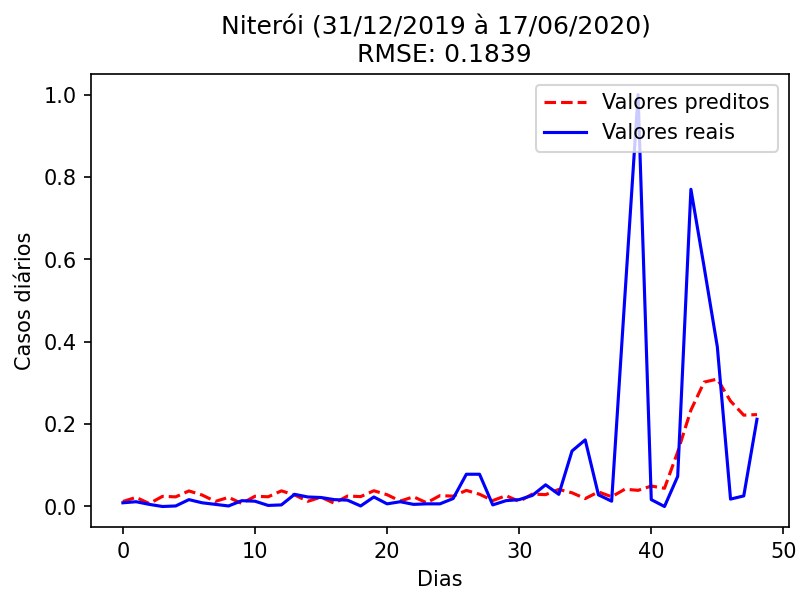

<Figure size 432x288 with 0 Axes>

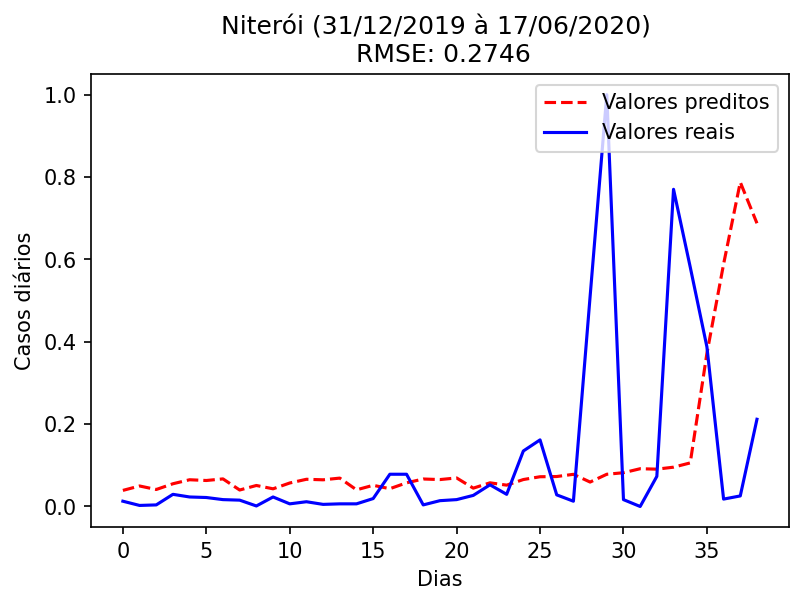

<Figure size 432x288 with 0 Axes>

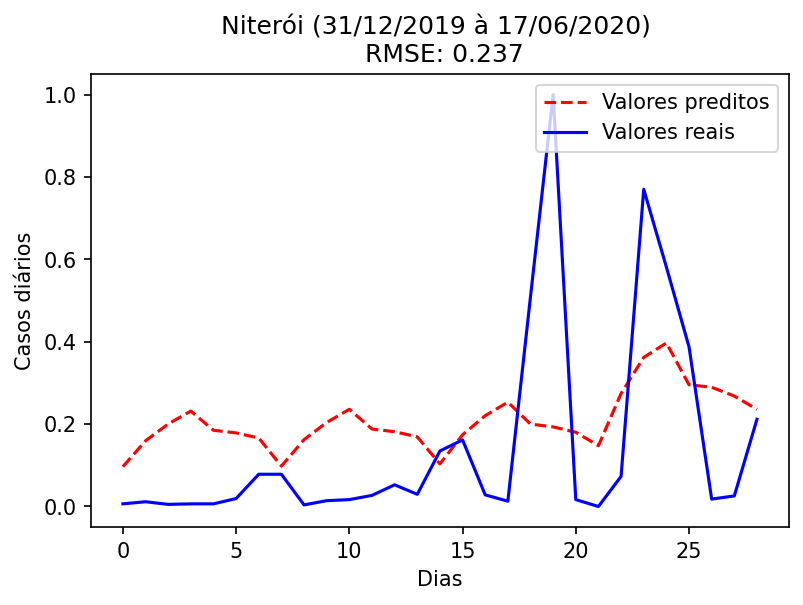

<Figure size 432x288 with 0 Axes>

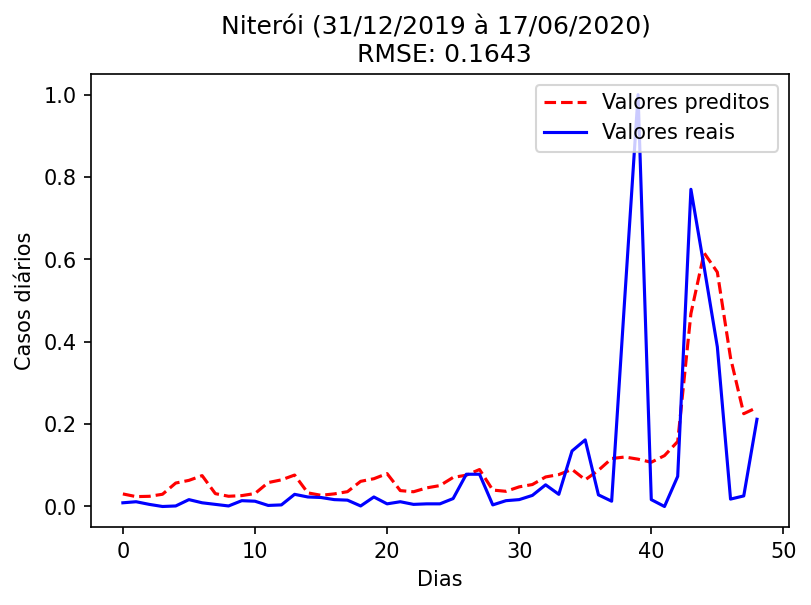

<Figure size 432x288 with 0 Axes>

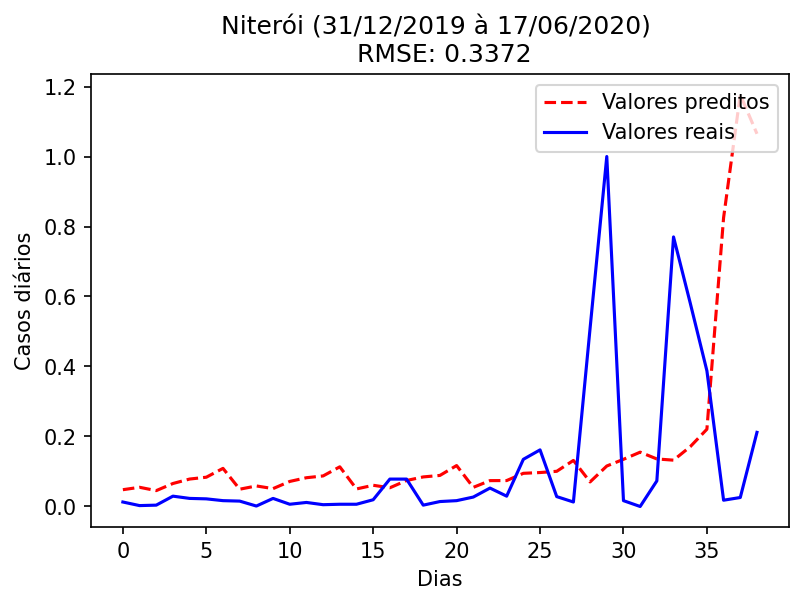

<Figure size 432x288 with 0 Axes>

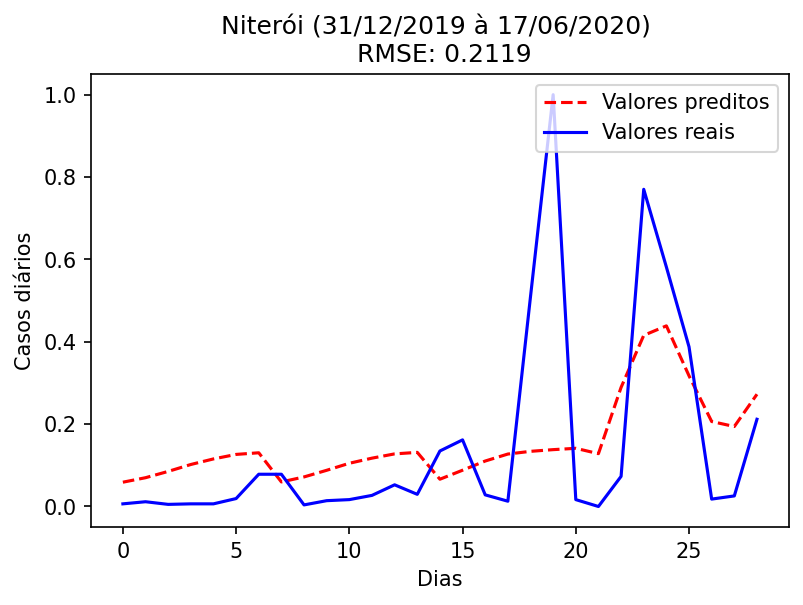

<Figure size 432x288 with 0 Axes>

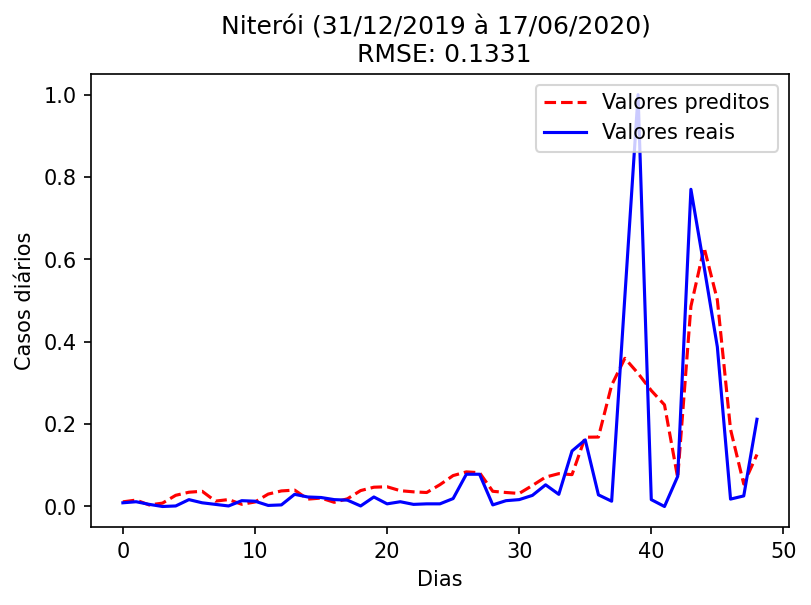

<Figure size 432x288 with 0 Axes>

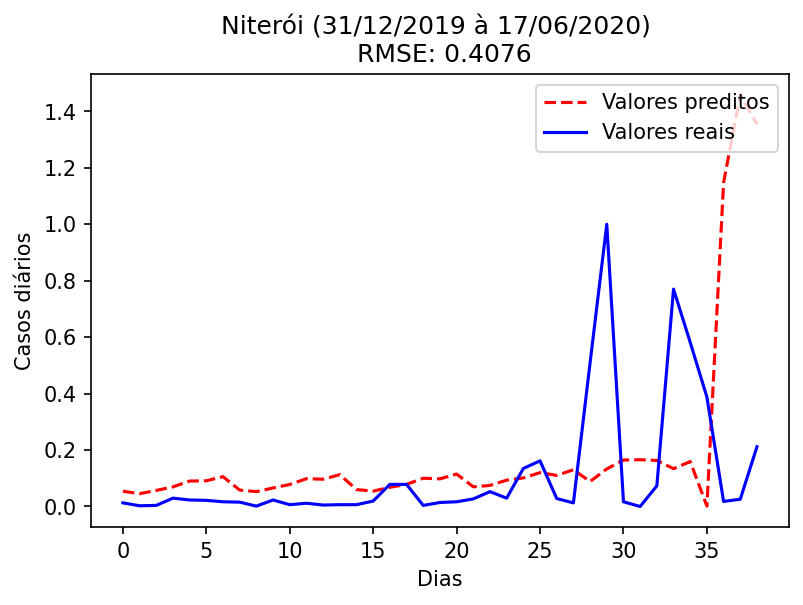

<Figure size 432x288 with 0 Axes>

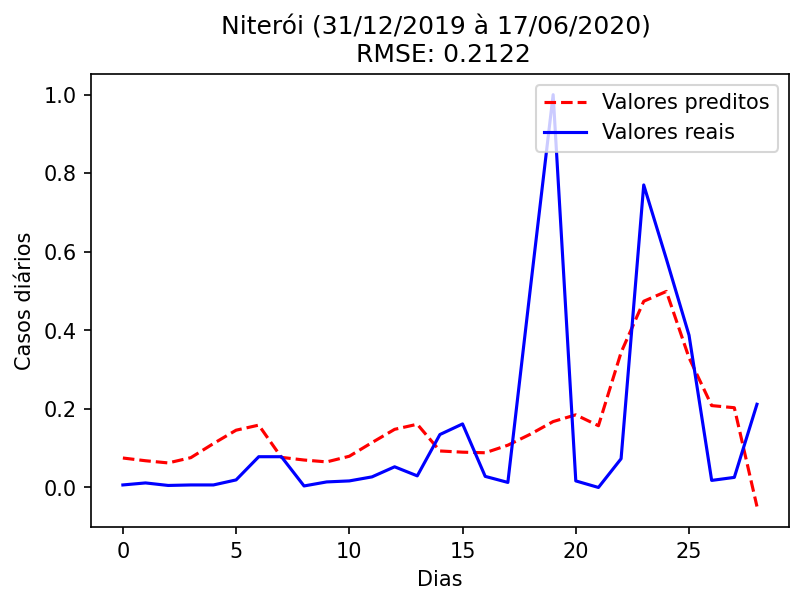

<Figure size 432x288 with 0 Axes>

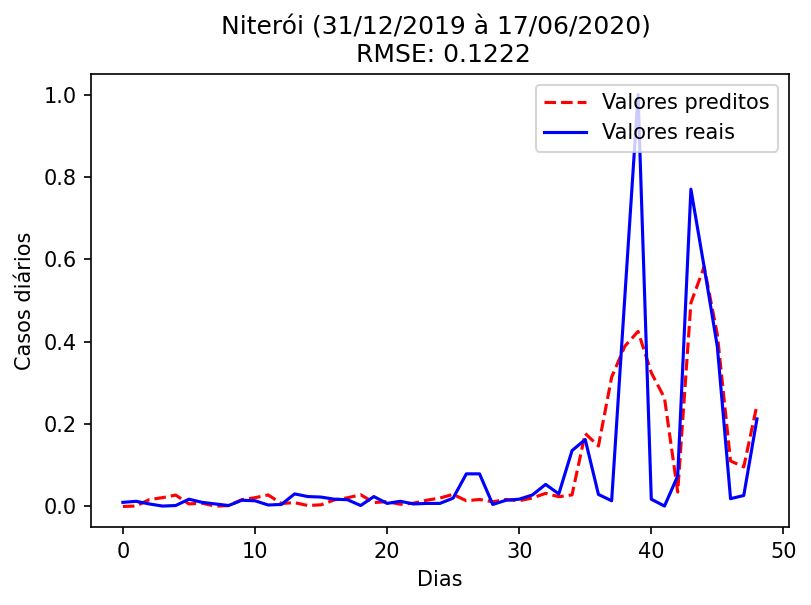

<Figure size 432x288 with 0 Axes>

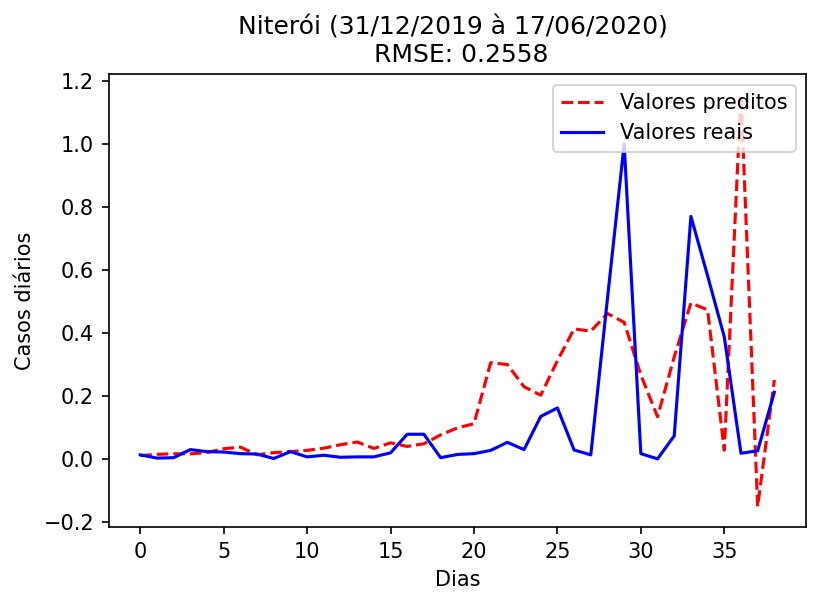

<Figure size 432x288 with 0 Axes>

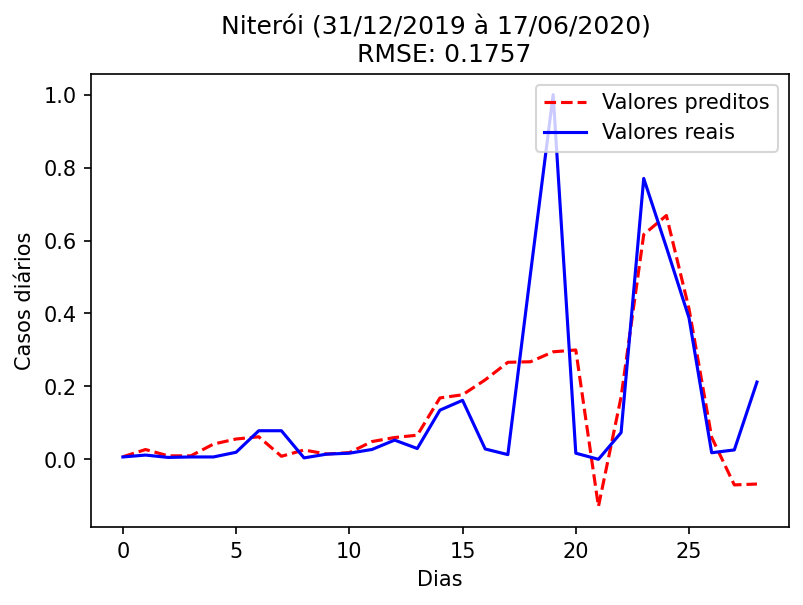

<Figure size 432x288 with 0 Axes>

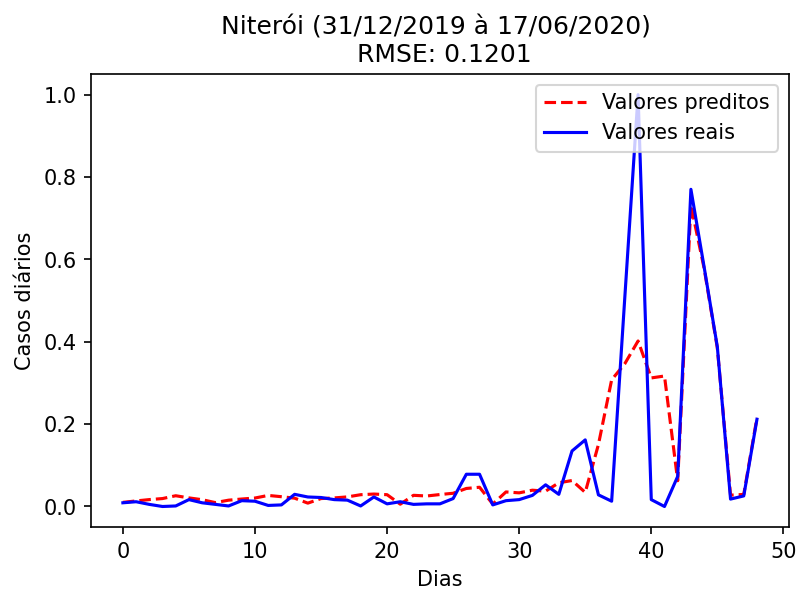

<Figure size 432x288 with 0 Axes>

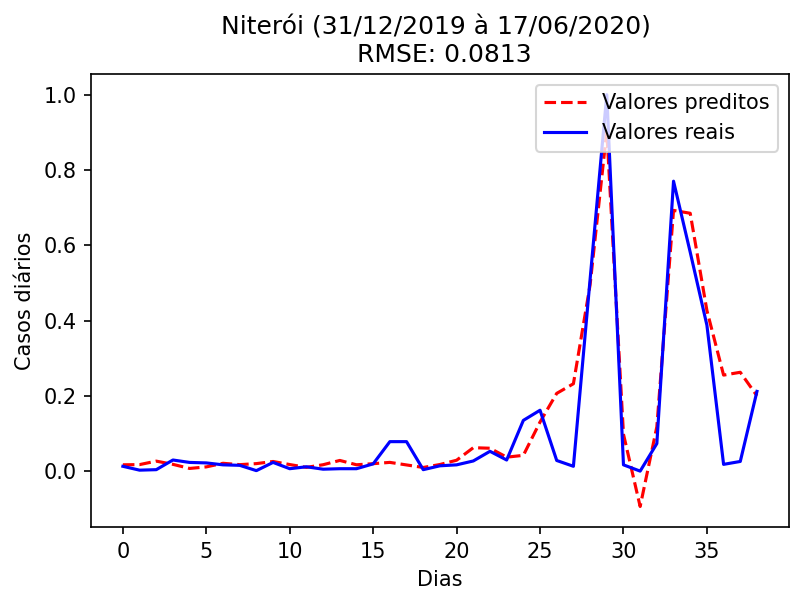

<Figure size 432x288 with 0 Axes>

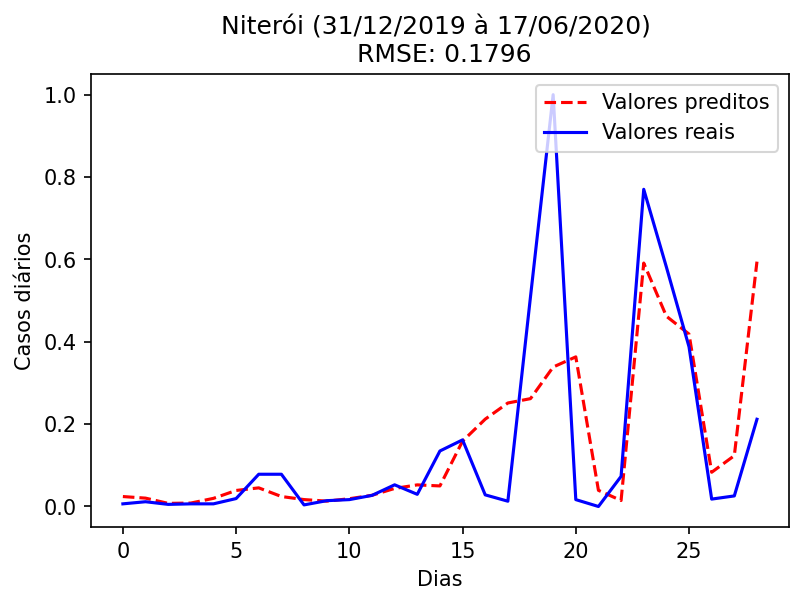

In [16]:
walk_epochs = [
   5, 10, 20, 50, 100
]

nt_paramsrange = multiplas_execucoes("Niteroi", [(10, 7), (20, 7), (30, 7)], 
                                "Niterói (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", 
                                epochs_range = walk_epochs, is_walk = True)

In [18]:
nt_paramsrange.to_csv("/content/drive/My Drive/paramsrange_niteroi.csv")

# Melhor modelo

Esta seção apresenta a execução do modelo que apresentou melhor desempenho aos dados. Abaixo, para iniciar, é feita a execução do modelo que teve o melhor desempenho.

Para a identificação do melhor modelo, faz-se a busca por aquele que apresenta o menor RMSE, como apresentado abaixo.


In [19]:
nt_paramsrange[nt_paramsrange['rmse'] == nt_paramsrange['rmse'].min()]

,nome_modelo,versao,entradas,rmse,epoch
1,Modelo_Niteroi_v1,v1,"(20, 7)",0.081348,100


Com o modelo identificado, seu treinamento é feito novamente para que seja possível realizar sua aplicação para a previsão dos dados

In [20]:
gerarTreinamento_parametros("Niteroi", "winner", 20, 7, epochs = 100)

Epoch 1/100
33/33 [==============================] - 1s 45ms/step - loss: 0.0592
Epoch 2/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0550
Epoch 3/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0525
Epoch 4/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0512
Epoch 5/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0487
Epoch 6/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0487
Epoch 7/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0471
Epoch 8/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0482
Epoch 9/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0459
Epoch 10/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0456
Epoch 11/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0449
Epoch 12/100
33/33 [==============================] - 1s 29ms/step - loss: 0.0442
Epoch 13/100
33/33 [=====

Com o modelo treinamento novamente, faz-se a validação de sua qualidade frente a predição dos dados

entrou condi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


<Figure size 432x288 with 0 Axes>

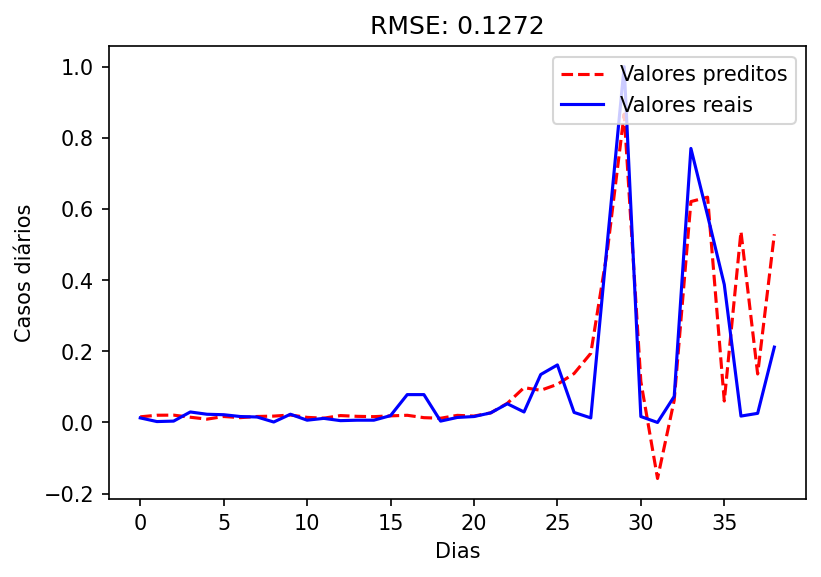

In [21]:
# pontos de entrada
n_entrada = 20
# pontos de saida
n_saida = 7
general_score = geraValidacao("Niteroi", "Modelo_Niteroi_winner", n_entrada, n_saida)

**Teste do modelo gerado**

Text(0.5, 1.0, 'Predição de casos diários de COVID-19 para os próximos 7 dias')

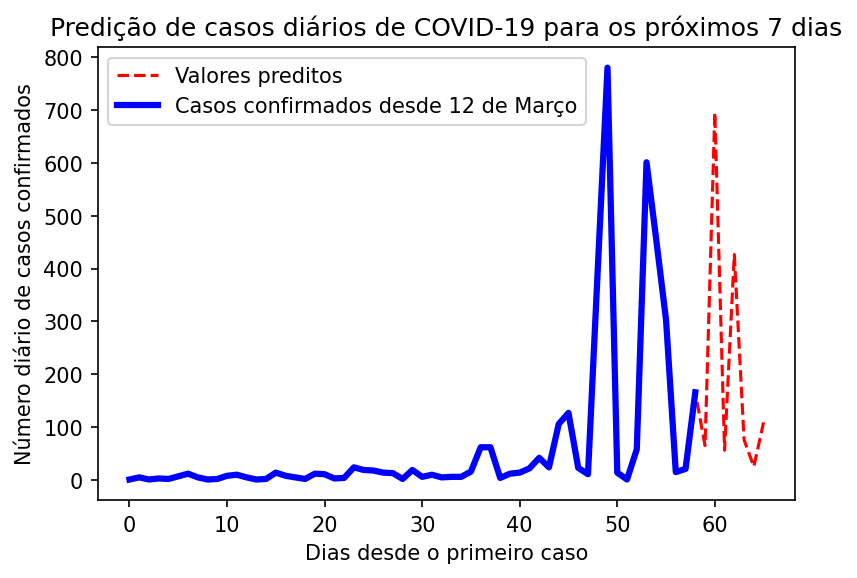

In [25]:
plt.figure(dpi = 150)
modelo = carregaModelo('Modelo_Niteroi_winner')

daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", "Niteroi")
dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)

input_array_2 =  np.array(dados_covid[-20:])

y_predict_val = predict(modelo,input_array_2, n_entrada)
predicted_serie = np.concatenate((dados_covid, y_predict_val))
predicted_serie_transform = scaler.inverse_transform(predicted_serie.reshape(len(predicted_serie),1))
dados_covid_transform = scaler.inverse_transform(dados_covid.reshape(len(dados_covid),1))

plt.plot(predicted_serie_transform, 'r--', label = 'Valores preditos')
plt.plot(dados_covid_transform, 'b', label = 'Casos confirmados desde 12 de Março', linewidth=3.0)

plt.xlabel('Dias desde o primeiro caso')
plt.ylabel('Número diário de casos confirmados')
plt.legend(loc ='upper left')
plt.title('Predição de casos diários de COVID-19 para os próximos 7 dias')